In [43]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multihash as mh
import hashlib as hl
from cid import make_cid
from math import log2
import psycopg2

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12, 8)

db_con = psycopg2.connect(
    host="localhost",
    port="5432",
    database="cid_hoarder_k15_hops",
    user="hoarder",
    password="password")

In [44]:
def get_in_degree(org, new) -> int:
    in_degree = 0
    for new_peer in new:
        if new_peer in org:
            in_degree += 1
    return in_degree

def hash_int_from_peer_id(peer_id: str) -> int:
    multihash = mh.from_b58_string(peer_id)
    hash_b = hl.sha256(multihash).digest()
    return int.from_bytes(hash_b, byteorder='big')

def hash_int_from_cid(cid: str) -> int:
    cid = make_cid(cid)
    cid_hash = hl.sha256(cid.multihash).digest()
    return int.from_bytes(cid_hash, byteorder='big')


def get_xor_distance(base: int, comp: int) -> int:
    return abs(base ^ comp)

In [45]:
ping_rounds = pd.read_sql_query("""select ping_round from fetch_results group by ping_round order by ping_round ASC;""", db_con)

In [46]:
# Get the CID Publish times for the CIDs
pub_times = pd.read_sql_query("""
    select cid_hash, gen_time from cid_info order by cid_hash;
    """, db_con)

# Get total pub time 
mn = min(pub_times['gen_time'])
mx = max(pub_times['gen_time'])

pub_t = (mx - mn) / 60 # conver to mins
print(f'{pub_t} mins to publish the CIDs')
    

2.2333333333333334 mins to publish the CIDs


In [47]:
# get the median time of each fetch time
   
hours_dist = []
for idx, row in ping_rounds.iterrows():
    # get the fetch times
    fetch_round = pd.read_sql_query(f"""
        select cid_hash, fetch_time from fetch_results where ping_round={row['ping_round']} order by cid_hash;
        """, db_con)
    fetch_round['time of pub'] = (fetch_round['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
    pp = fetch_round['time of pub'].to_numpy()
    hours_dist.append(np.median(pp))

In [48]:
# Get PR Holders for each CID
pr_holders = pd.read_sql_query("""select cid_hash, peer_id from pr_holders order by cid_hash;""", db_con)

init_holders = {}
for i, r in pr_holders.iterrows():
    if r['cid_hash'] not in init_holders:
        init_holders[r['cid_hash']] = []
    init_holders[r['cid_hash']].append(r['peer_id'])
    
in_degree_dist = []

init_in_degree = []
# Get in-degree of the first round - should give 10/10 
for cid in init_holders:
    in_d = get_in_degree(init_holders[cid], init_holders[cid])
    init_in_degree.append(in_d)

in_degree_dist.append(init_in_degree)

for i, r in ping_rounds.iterrows():
    print(f"round {r['ping_round']}/{len(ping_rounds)}")
    if r['ping_round'] == 0: # first round has no closest peers
        continue
    
    # get the closest peers for that ping round
    round_close_peers = {}
    close_peers = pd.read_sql_query(f"""
    select cid_hash, peer_id from k_closest_peers where ping_round={r['ping_round']} order by cid_hash;
    """, db_con)
    
    for i, r in close_peers.iterrows():
        if r['cid_hash'] not in round_close_peers:
            round_close_peers[r['cid_hash']] = []
        
        round_close_peers[r['cid_hash']].append(r['peer_id'])
    
    # calculate the in-degree ratio of the init_holders 
    round_close_p_dist = []
    for c in init_holders:
        in_d = 0
        try:
            in_d = get_in_degree(init_holders[c], round_close_peers[c])    
        except:
            in_d = 0
        round_close_p_dist.append(in_d) 
    in_degree_dist.append(round_close_p_dist)



round 0/74
round 1/74
round 2/74
round 3/74
round 4/74
round 5/74
round 6/74
round 7/74
round 8/74
round 9/74
round 10/74
round 11/74
round 12/74
round 13/74
round 14/74
round 15/74
round 16/74
round 17/74
round 18/74
round 19/74
round 20/74
round 21/74
round 22/74
round 23/74
round 24/74
round 25/74
round 26/74
round 27/74
round 28/74
round 29/74
round 30/74
round 31/74
round 32/74
round 33/74
round 34/74
round 35/74
round 36/74
round 37/74
round 38/74
round 39/74
round 40/74
round 41/74
round 42/74
round 43/74
round 44/74
round 45/74
round 46/74
round 47/74
round 48/74
round 49/74
round 50/74
round 51/74
round 52/74
round 53/74
round 54/74
round 55/74
round 56/74
round 57/74
round 58/74
round 59/74
round 60/74
round 61/74
round 62/74
round 63/74
round 64/74
round 65/74
round 66/74
round 67/74
round 68/74
round 69/74
round 70/74
round 71/74
round 72/74
round 73/74


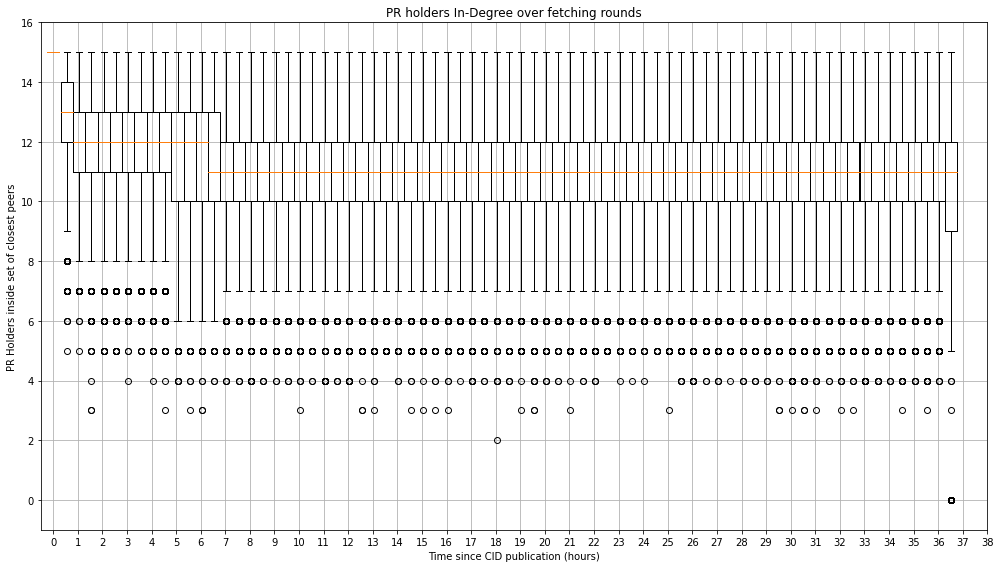

In [49]:
# Plot in-degree of PR Holders in K closest peers over time
  
fig, ax = plt.subplots(figsize=(14, 8))
ax.boxplot(in_degree_dist, positions=hours_dist, showfliers=True) 
ax.set_xlabel("Time since CID publication (hours)")
ax.set_ylabel("PR Holders inside set of closest peers")

# set net xticks to int hours
ticks = np.arange(np.round(hours_dist[-1])+2)
ax.set_xticks(ticks, ticks.astype(int))
ax.set_ylim(-1, max(in_degree_dist[0])+1)


plt.title(f"PR holders In-Degree over fetching rounds")
plt.grid()
plt.tight_layout()
plt.show()

In [16]:
# Compare the distance between a random CID and the PR Holders vs K Closest Peers
c = pd.read_sql_query("select cid_hash from cid_info where id=2", db_con)
CID = c['cid_hash'][0]
cid_hash_int = hash_int_from_cid(CID)

# Get the peer_id sets for a single CID (PR Holders and Kclosest peers of the first round)
pr_holders = pd.read_sql_query(f"select peer_id from pr_holders where cid_hash='{CID}';", db_con)
tot_peers = pd.read_sql_query(f"select peer_id from peer_info;", db_con)


# Get the hash value and hash_int of each of the sets
pr_holders['xor_dist'] = pr_holders.apply(lambda row: get_xor_distance(cid_hash_int, hash_int_from_peer_id(row['peer_id'])) , axis=1)
pr_holders['xor_dist_log2'] = pr_holders.apply(lambda row: log2(row['xor_dist']), axis=1)
pr_holders['xor_dist_normed'] = pr_holders['xor_dist'] / (2**256 - 1) * 100


tot_peers['xor_dist'] = tot_peers.apply(lambda row: get_xor_distance(cid_hash_int, hash_int_from_peer_id(row['peer_id'])) , axis=1)
tot_peers['xor_dist_log2'] = tot_peers.apply(lambda row: log2(row['xor_dist']), axis=1)
tot_peers['xor_dist_normed'] = tot_peers['xor_dist'] / (2**256 - 1) * 100

pr_holders = pr_holders.sort_values('xor_dist')
tot_peers = tot_peers.sort_values('xor_dist')

ln_tot = np.linspace(0, len(tot_peers), len(tot_peers))
ln_p = np.linspace(0, len(pr_holders), len(pr_holders))


Text(0.5, 1.0, 'CID xor distance with set of peers')

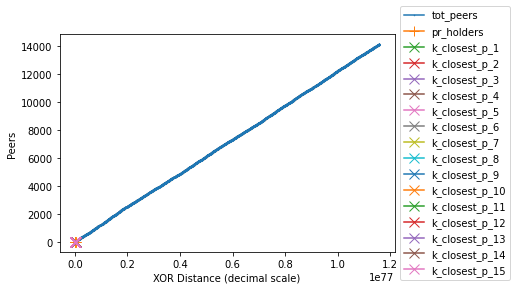

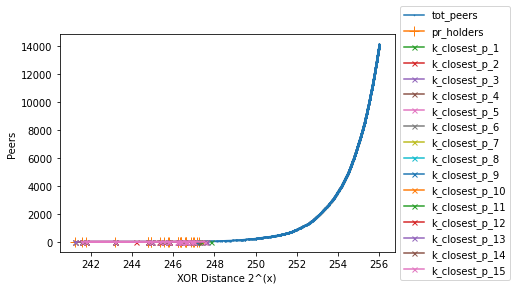

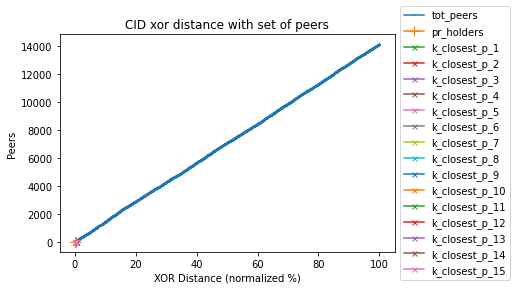

In [17]:
fig_xor, ax_xor = plt.subplots()

ax_xor.plot(tot_peers['xor_dist'], ln_tot, marker='.',  ms=1, label='tot_peers')
ax_xor.plot(pr_holders['xor_dist'], ln_p, marker='+', ms=10.0, label='pr_holders')

fig_xor_log2, ax_xor_log2 = plt.subplots()
ax_xor_log2.plot(tot_peers['xor_dist_log2'], ln_tot, marker='.',  ms=1, label='tot_peers')
ax_xor_log2.plot(pr_holders['xor_dist_log2'], ln_p, marker='+', ms=10.0, label='pr_holders')

fig_xor_normed, ax_xor_normed = plt.subplots()
ax_xor_normed.plot(tot_peers['xor_dist_normed'], ln_tot, marker='.',  ms=1, label='tot_peers')
ax_xor_normed.plot(pr_holders['xor_dist_normed'], ln_p, marker='+', ms=10.0, label='pr_holders')

for i, row in ping_rounds.iterrows():
    if i > 15:
        break
    k_close_p = pd.read_sql_query(f"select peer_id from k_closest_peers where cid_hash='{CID}' and ping_round={row['ping_round']};", db_con)
    if len(k_close_p) == 0:
        continue
    k_close_p['xor_dist'] = k_close_p.apply(lambda row: get_xor_distance(cid_hash_int, hash_int_from_peer_id(row['peer_id'])), axis=1)
    k_close_p['xor_dist_log2'] = k_close_p.apply(lambda row: log2(row['xor_dist']), axis=1)
    k_close_p['xor_dist_normed'] = k_close_p['xor_dist'] / (2**256 - 1) * 100
    
    ln_p = np.linspace(0, len(k_close_p), len(k_close_p))
    ax_xor.plot(k_close_p['xor_dist'], ln_p, marker='x', ms=10.0, label=f"k_closest_p_{row['ping_round']}")
    ax_xor_log2.plot(k_close_p['xor_dist_log2'], ln_p, marker='x', ms=5.0, label=f"k_closest_p_{row['ping_round']}")
    ax_xor_normed.plot(k_close_p['xor_dist_normed'], ln_p, marker='x', ms=5.0, label=f"k_closest_p_{row['ping_round']}")

ax_xor.set_xlabel('XOR Distance (decimal scale)')
ax_xor.set_ylabel('Peers')
ax_xor.axis('tight')
ax_xor.legend()
ax_xor.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax_xor_log2.set_xlabel('XOR Distance 2^(x)')
ax_xor_log2.set_ylabel('Peers')
ax_xor_log2.axis('tight')
ax_xor_log2.legend()
ax_xor_log2.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax_xor_normed.set_xlabel('XOR Distance (normalized %)')
ax_xor_normed.set_ylabel('Peers')
ax_xor_normed.axis('tight')
ax_xor_normed.legend()
ax_xor_normed.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.title('CID xor distance with set of peers')

Text(0.5, 1.0, 'CID xor distance with set of peers')

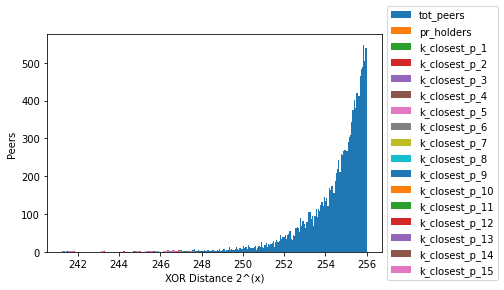

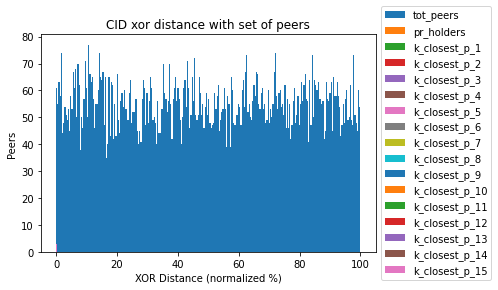

In [18]:
#fig_xor, ax_xor = plt.subplots()

#ax_xor.hist(tot_peers['xor_dist'].to_numpy(dtype=float), bins=200, label='tot_peers')
#ax_xor.hist(pr_holders['xor_dist'].to_numpy(dtype=float), bins=1, label='pr_holders')

fig_xor_log2, ax_xor_log2 = plt.subplots()
ax_xor_log2.hist(tot_peers['xor_dist_log2'].to_numpy(dtype=float), bins=256, label='tot_peers')
ax_xor_log2.hist(pr_holders['xor_dist_log2'].to_numpy(dtype=float), bins=50, label='pr_holders')

fig_xor_normed, ax_xor_normed = plt.subplots()
ax_xor_normed.hist(tot_peers['xor_dist_normed'].to_numpy(dtype=float), bins=256, label='tot_peers')
ax_xor_normed.hist(pr_holders['xor_dist_normed'].to_numpy(dtype=float), bins=50, label='pr_holders')


for i, row in ping_rounds.iterrows():
    if i > 15:
        break
    k_close_p = pd.read_sql_query(f"select peer_id from k_closest_peers where cid_hash='{CID}' and ping_round={row['ping_round']};", db_con)
    if len(k_close_p) == 0:
        continue
    k_close_p['xor_dist'] = k_close_p.apply(lambda row: get_xor_distance(cid_hash_int, hash_int_from_peer_id(row['peer_id'])), axis=1)
    k_close_p['xor_dist_log2'] = k_close_p.apply(lambda row: log2(row['xor_dist']), axis=1)
    k_close_p['xor_dist_normed'] = k_close_p['xor_dist'] / (2**256 - 1) * 100

    #ax_xor.hist(k_close_p['xor_dist'].to_numpy(dtype=float), bins=200, label=f"k_closest_p_{row['ping_round']}")
    ax_xor_normed.hist(k_close_p['xor_dist_normed'].to_numpy(dtype=float), bins=50, label=f"k_closest_p_{row['ping_round']}")
    ax_xor_log2.hist(k_close_p['xor_dist_log2'].to_numpy(dtype=float), bins=50, label=f"k_closest_p_{row['ping_round']}")


ax_xor.set_xlabel('XOR Distance (decimal scale)')
ax_xor.set_ylabel('Peers')
ax_xor.axis('tight')
ax_xor.legend()
ax_xor.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax_xor_log2.set_xlabel('XOR Distance 2^(x)')
ax_xor_log2.set_ylabel('Peers')
ax_xor_log2.axis('tight')
ax_xor_log2.legend()
ax_xor_log2.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax_xor_normed.set_xlabel('XOR Distance (normalized %)')
ax_xor_normed.set_ylabel('Peers')
ax_xor_normed.axis('tight')
ax_xor_normed.legend()
ax_xor_normed.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.title('CID xor distance with set of peers')

Analysis of the Normed XOR distance between the CIDs and the PR Holders IDs 
(https://github.com/dennis-tra/optimistic-provide#normed-xor-distance)


In [ ]:

# Get the peer_id sets for a single CID (PR Holders and Kclosest peers of the first round)
pr_holders = pd.read_sql_query(f"select cid_hash, peer_id from pr_holders;", db_con)
k_close_p = pd.read_sql_query(f"select cid_hash, ping_round, peer_id from k_closest_peers limit 500000;", db_con)


# Get the hash value and hash_int of each of the sets
pr_holders['xor_dist'] = pr_holders.apply(lambda row: get_xor_distance(hash_int_from_cid(row['cid_hash']), hash_int_from_peer_id(row['peer_id'])) , axis=1)
pr_holders['xor_dist_log2'] = pr_holders.apply(lambda row: log2(row['xor_dist']), axis=1)
pr_holders['xor_dist_normed'] = pr_holders['xor_dist'] / (2**256 - 1) * 100


k_close_p['xor_dist'] = k_close_p.apply(lambda row: get_xor_distance(hash_int_from_cid(row['cid_hash']), hash_int_from_peer_id(row['peer_id'])), axis=1)
k_close_p['xor_dist_log2'] = k_close_p.apply(lambda row: log2(row['xor_dist']), axis=1)
k_close_p['xor_dist_normed'] = k_close_p['xor_dist'] / (2**256 - 1) * 100

print(k_close_p['xor_dist_normed'])

pr_holders = pr_holders.sort_values('xor_dist')
k_close_p = k_close_p.sort_values('xor_dist')

ln_p = np.linspace(0, len(pr_holders), len(pr_holders))
k_p = np.linspace(0, len(k_close_p), len(k_close_p))

plt.plot(k_close_p['xor_dist_normed'], k_p, marker='+', ms=3.0, label='k_close_peers')
plt.plot(pr_holders['xor_dist_normed'], ln_p, marker='x', ms=3.0, label='pr_holders')
plt.ylabel('Distance CDF')
plt.xlabel('Normed XOR distance in %')
plt.title('Normed XOR distance CDF between CID and PR Holders vs K Closest Peers')
plt.legend()
plt.show()

plt.plot(k_close_p['xor_dist_log2'], k_p, marker='+', ms=3.0, label='k_close_peers')
plt.plot(pr_holders['xor_dist_log2'], ln_p, marker='x', ms=3.0, label='pr_holders')
plt.ylabel('Distance CDF')
plt.xlabel('XOR distance 2^(x)')
plt.title('Base 2 XOR distance CDF between CID and PR Holders vs K Closest Peers')
plt.legend()
plt.show()


In [ ]:

pr_h = np.array(pr_holders['xor_dist_log2'], dtype=float)
k_clos = np.array(k_close_p['xor_dist_log2'], dtype=float)

plt.hist(k_clos, bins=300, label='k_close_peers')
plt.hist(pr_h, bins=300, label='pr_holders')
plt.ylabel('Distance PDF')
plt.xlabel('XOR distance 2^(x)')
plt.title('Base 2 XOR distance PDF between CID and PR Holders vs K Closest Peers')
plt.legend()
plt.show()

pr_h_normed = np.array(pr_holders['xor_dist_normed'], dtype=float)
k_clos_normed = np.array(k_close_p['xor_dist_normed'], dtype=float)

plt.hist(k_clos_normed, bins=300, label='k_close_peers')
plt.hist(pr_h_normed, bins=300, label='pr_holders')
plt.ylabel('Distance PDF')
plt.xlabel('Normed XOR distance in %')
plt.title('Normed XOR distance PDF between CID and PR Holders vs K Closest Peers')
plt.legend()
plt.show()


In [ ]:
db_con.close()